In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.animation as animation
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame
import sys
import pickle
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')


%matplotlib widget

In [2]:
def load_files(files):
    s21s = []
    for i, file in enumerate(files):
        freqs, s21 = np.load(file)
        s21s.append(s21)
    return freqs, np.array(s21s)

def track_tones(s21, locs, limit=5):
    for i, loc in enumerate(locs):
        init_loc = copy(loc)
        prev = s21[loc-1]
        now = s21[loc]
        next = s21[loc+1]
        if next < now:
            while next < now:
                loc += 1
                prev = now
                now = next
                next = s21[loc+1]
        elif next > now:
            while prev < now:
                loc -= 1
                next = now
                now = prev
                prev = s21[loc-1]
        elif next >= now and prev <= now:
            print('At min: ', i)
        else:
            print('No min: ', i)
        if abs(loc - init_loc) <= limit:
            locs[i] = loc
        else:
            print('Too far: ', i)   
    _, unique_indices = np.unique(locs, return_index=True)
    unique_mask = np.zeros(locs.shape, dtype=bool)
    unique_mask[unique_indices] = True
    return locs, unique_mask

def smooth_sweep(s21):
    window_length = 5
    polyorder = 3
    smooth_s21 = savgol_filter(s21, window_length, polyorder)
    return smooth_s21

def readout_tones(tones, s21s, dark):
    s21_mins = dark[tones]
    nr_kids = len(tones)
    nr_scans = s21s.shape[0]
    ds21s = np.empty((nr_scans, nr_kids))
    for i, s21 in enumerate(s21s):
        # smooth_s21 = smooth_sweep(s21)
        smooth_s21 = s21
        ds21s[i, :]  = smooth_s21[tones] - s21_mins
    return ds21s

def get_pos(ds21s, mpp):
    nr_kids = ds21s.shape[1]
    pos = np.empty((nr_kids)) # f0, 
    pos[:] = np.nan
    maxproms = np.empty((nr_kids)) # f0, 
    maxproms[:] = np.nan
    secproms = np.empty((nr_kids)) # f0, 
    secproms[:] = np.nan
    doubles = []
    for i in range(nr_kids):
        ds21 = ds21s[:, i]
        y = medfilt(ds21, 3)
        x = np.arange(len(y))
        a, b = np.polyfit(x, y, 1)
        ds21 -= (a*x + b)
        ds21s[:, i] = ds21
        baseline = y - (a*x + b)
        argsort = np.argsort(ds21)
        argmax = argsort[-1]
        secargmax = argsort[-2]
        max = ds21[argmax]
        secmax = ds21[secargmax]
        mean = np.mean(baseline)
        maxprom = max - mean
        secprom =  secmax - mean
        pos[i] = argmax
        maxproms[i] = maxprom
        secproms[i] = secprom
        if secprom >= mpp: 
            if len(doubles):
                if doubles[-1] != i-1:
                    doubles.append(i)
                else:
                    doubles = doubles[:-1]
            else:
                doubles.append(i)
    print('Mean prominence: ', np.mean(maxproms))
    fig, ax = plt.subplot_mosaic('ab', figsize=(4,2))
    hist = ax['a'].hist(pos, bins=np.arange(ds21s.shape[0]+1), facecolor='tab:blue', edgecolor='w')
    ax['b'].axvline(mpp, c='r')
    # ax['a'].axhline(nr_rows, c='r')
    ax['b'].hist(maxproms, bins='auto')
    ax['b'].hist(secproms, bins='auto')
    print('total: ', np.sum(~np.isnan(pos)))
    print('nr doubles: ', len(doubles))
    print(doubles)
    return pos, maxproms, secproms, doubles

def add_kids(added, to_add):
    global rows, cols, maxproms, secproms, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    added = np.array(added, dtype=int)
    to_add = np.array(to_add, dtype=int)
    secargmax_rows = np.argsort(ds21s_rows[:, to_add], axis=0)[-2, :]
    rows = np.insert(rows, to_add, secargmax_rows)
    ds21s_rows = np.insert(ds21s_rows, to_add, ds21s_rows[:, to_add], axis=1)
    secargmax_cols = np.argsort(ds21s_cols[:, to_add], axis=0)[-2, :]
    cols = np.insert(cols, to_add, secargmax_cols)
    ds21s_cols = np.insert(ds21s_cols, to_add, ds21s_cols[:, to_add], axis=1)
    maxproms = np.insert(maxproms, to_add, secproms[to_add])
    secproms = np.insert(secproms, to_add, maxproms[to_add])
    f0s = np.insert(f0s, to_add, f0s[to_add])
    locs = np.insert(locs, to_add, locs[to_add])
    to_add = np.sort(to_add)
    to_add += np.arange(len(to_add))
    for kid in to_add:
        added[added >= kid] += 1
        added = np.hstack((added, kid, kid+1))
    return list(np.sort(added))

def del_kids(added, to_delete):
    global rows, cols, maxproms, secproms, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    to_delete = np.sort(to_delete)
    to_delete = np.array(to_delete, dtype=int)
    added = np.array(added, dtype=int)
    
    rows = np.delete(rows, to_delete)
    cols = np.delete(cols, to_delete)
    maxproms = np.delete(maxproms, to_delete)
    secproms = np.delete(secproms, to_delete)
    f0s = np.delete(f0s, to_delete)
    ds21s_rows = np.delete(ds21s_rows, to_delete, axis=1)
    ds21s_cols = np.delete(ds21s_cols, to_delete, axis=1)
    locs = np.delete(locs, to_delete)
    for kid in to_delete[::-1]:
        if kid in added:
            added = np.delete(added, np.argwhere(added == kid))
        if kid-1 in added: 
            added = np.delete(added, np.argwhere(added == kid-1))
        elif kid+1 in added: 
            added = np.delete(added, np.argwhere(added == kid+1))
        added[added >= kid] -= 1
    return list(added)

def plot_dipshit(s21s, ds21s, pos, kids, steps=[], bw=50):
    global f0s, locs, freqs, smooth_avg_s21
    fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
    custom_colors = ['b', 'y', 'g', 'p']

    for kid in kids:
        ds21 = ds21s[:, kid]
        baseline = medfilt(ds21, 3)
        res = f0s[kid]
        loc = locs[kid]
        index = np.arange(loc-bw,loc+bw)
        hit = int(pos[kid])
        ax['b'].axhline(np.mean(baseline), ls='--', lw=1, c='k')
        ax['a'].plot(freqs[index], smooth_avg_s21[index], lw=2, label='dark', c='k')
        ax['a'].axvline(res, c='k', ls='--', lw=1)
        ax['a'].plot(freqs[index], smooth_sweep(s21s[hit, index]), lw=2, label='hit @' + str(hit), c='r')
        ax['b'].axvline(hit, ls='--', lw=2, c='r')
        for i, step in enumerate(steps):
            ax['a'].plot(freqs[index], smooth_sweep(s21s[step, index]), lw=1, label=str(step), c=custom_colors[i])
            ax['b'].axvline(step, ls='--', lw=1, c=custom_colors[i])
        ax['b'].plot(ds21, lw=2, label=str(kid), c='k')
    ax['b'].legend()
    ax['a'].legend()

def plot_rows(rows, doubles=[], lo=None):    
    global f0s, nr_cols
    fig, ax = plt.subplot_mosaic('aaaab', figsize=(14,9), constrained_layout=True, sharey=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(f0s, rows, c=maxproms, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='vertical', location='left')
    cbar.set_label('Max Prominence')
    for id, row in enumerate(rows):
        ax['a'].annotate(id, (f0s[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(f0s[id], rows[id], marker='o', facecolor='None', edgecolor='k', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_yticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axvline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', orientation='horizontal', label=['< LO', '> LO'], stacked=True)
        ax['b'].axvline(nr_cols/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w', orientation='horizontal')
    ax['b'].axvline(nr_cols, c='k', ls='-', lw=2)
    ax['b'].legend()

def plot_cols(rows, doubles=[], lo=None):    
    global f0s, nr_rows
    fig, ax = plt.subplot_mosaic('b;a;a;a;a', figsize=(9,14), constrained_layout=True, sharex=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(rows, f0s, c=maxproms, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='horizontal', location='bottom')
    cbar.set_label('Max Prominence')
    for id, col in enumerate(rows):
        ax['a'].annotate(id, (col+.3, f0s[id]), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(rows[id], f0s[id], marker='o', facecolor='None', edgecolor='k', linewidth=2)
        ax['a'].scatter(rows[id+1], f0s[id+1], marker='o', facecolor='None', edgecolor='k', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_xticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axhline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', label=['< LO', '> LO'], stacked=True)
        ax['b'].axhline(nr_rows/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w')
    ax['b'].axhline(nr_rows, c='k', ls='-', lw=2)
    ax['b'].legend()

def map_kids(nans, roll):
    global rows, nr_rows, nr_cols
    row_list = [[] for _ in range(nr_rows)]
    for id, row in enumerate(rows):
        if not np.isnan(row):
            row_list[int(row)].append(int(id))
    map_sorted = np.empty((nr_rows, nr_cols))
    map_sorted[:] = np.nan   
    for i, row in enumerate(row_list):
        map_sorted[i, :len(row)] = row
    for i, j in nans:
        map_sorted[i, j+1:] = map_sorted[i, j:-1]
        map_sorted[i, j] = np.nan
    map = copy(map_sorted)
    for i, row in enumerate(map_sorted):
        map[i] = np.roll(row, i*roll)
    fig, ax = plt.subplot_mosaic('ab', figsize=(5,3), constrained_layout=True)
    ax['a'].imshow(map_sorted, cmap='viridis', origin='lower')
    ax['b'].imshow(map, cmap='viridis', origin='lower')
    return map

def common_mode(x, y, deg):
    global meas, nanmask
    coeff = np.polyfit(x, y, deg)
    cmode = np.poly1d(coeff)
    print(cmode)
    return cmode

def comp_scatter(deg):
    global design, meas, nanmask
    
    cmode = common_mode(design[~nanmask], meas[~nanmask], deg)
    design_fit = cmode(design)
    scatter = (meas - design_fit) / design_fit
    return scatter, cmode

def plot_scatter(deg=1, annotate=False, clim=[]):
    global design, meas, nanmask, kid_id_board, nr_rows, nr_cols, kids

    df_f, cmode = comp_scatter(deg)
    df_f_map = df_f[kid_id_board]
    flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])
    xfit = np.linspace(flim[0], flim[1])
    yfit = cmode(xfit)

    fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
    ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
    ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{meas}$')
    ax['a'].plot(xfit, yfit, c='k', label='common mode, deg=%d' % (len(cmode.c)-1), ls='--', lw=0.5)
    ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
    ax['a'].set_xlim(flim)
    ax['a'].set_ylim(flim)
    ax['a'].legend(loc='upper left')
    if not len(clim):
        clim = [np.amin(df_f[~nanmask]), np.amax(df_f[~nanmask])]
    ax['b'].scatter(design, df_f, c=df_f, vmin=clim[0], vmax=clim[1], label='residual')
    ax['b'].annotate
    ax['b'].set_ylabel('$\it df*/f$')
    ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
    if annotate:
        for i, x in enumerate(df_f_map):
            for j, y in enumerate(x):
                if ~np.isnan(y):
                    old_id = kid_id_board[i, j]
                    new_id = kids[i, j]
                    if old_id == new_id:
                        c = 'w'
                    else:
                        c = 'r'
                    ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=6, color='w', rotation=45)
    # Major ticks
    ax['c'].set_xticks(np.arange(0, nr_cols, 1)-0.5, minor=False)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1)-0.5, minor=False)
    ax['c'].set_xticks(np.arange(0, nr_cols, 1), minor=True)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1), minor=True)
    # Labels for major ticks
    ax['c'].set_xticklabels(np.arange(0, nr_cols, 1), minor=True, rotation=-90)
    ax['c'].set_yticklabels(np.arange(0, nr_rows, 1), minor=True, rotation=0)
    ax['c'].set_yticklabels([], minor=False)
    ax['c'].set_xticklabels([], minor=False)
    ax['c'].grid(which='major', linestyle='-', linewidth=0.5)
    ax['c'].grid(which='minor', visible=False)
    ax['c'].set_xlabel('$\it x$ $[px]$')
    ax['c'].set_ylabel('$\it y$ $[px]$')
    cbar = fig.colorbar(im, ax=ax['c'])
    _ = cbar.ax.set_ylabel('$\it df*/f$')

    scatter = np.std(df_f[~nanmask])
    pxl_yield = (np.sum(~np.isnan(meas))/(nr_rows*nr_cols))
    print('scatter = %.1f%%' % (scatter*1e2))
    print('yield = %.1f%%' % (pxl_yield*1e2))


def image(ds21s):
    global nr_rows, nr_cols

    nr_scans = ds21s.shape[0]
    maps = np.zeros((nr_rows, nr_cols, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    ds21s[:, k] -= np.amin(ds21s[:, k])
                    ds21s[:, k] /= np.amax(ds21s[:, k])
                    maps[i, j, nr] = ds21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan
    return maps

def plot_image(map, annotate=True):
    global kids
    
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.imshow(map, origin='lower', cmap='viridis')
    M, N = map.shape
    for i, x in enumerate(kids):
        for j, y in enumerate(x):
                if ~np.isnan(y):
                    new_id = kids[i, j]
                    ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
    # Major ticks
    ax.set_xticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_yticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_xticks(np.arange(0, M, 1), minor=True)
    ax.set_yticks(np.arange(0, M, 1), minor=True)
    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, N, 1), minor=True, rotation=0)
    ax.set_yticklabels(np.arange(0, M, 1), minor=True, rotation=0)
    ax.set_yticklabels([], minor=False)
    ax.set_xticklabels([], minor=False)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', visible=False)
    return fig, cax

def animate_image(maps, annotate=False, save=None):
    fig, cax = plot_image(maps[:,:, 0], annotate=annotate)
    nr_scans = maps.shape[2]
    def update(frame):
        cax.set_array(maps[:, :, frame])
        return cax,
    ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
    if save:
        ani.save(save, writer='Pillow')
    return ani

def rel_freqs(f0, f1, nr_kids):
    oct = np.log2(f1/f0)
    spacing = 2**(oct/(nr_kids-1))
    powers = np.arange(nr_kids)
    f0s = f0 * (spacing)**powers
    return f0s

In [3]:
master = {}
master['design'] = {}
dir  = r"C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\sonnet\LT402 Design/"
chip = 'LT402_20x20_5-7GHz'
path = dir + chip + '/'
headers = ['f0', 'Lc', 'Lf_pretrim', 'w']
keys = ['f0', 'couplers', 'fingers', 'widths']
for i, header in enumerate(headers):
    filepath = path + chip + '_' + header + '.npy'
    data = np.load(filepath)
    master['design'][keys[i]] = data
kid_id_board = np.load( path + chip + '_id.npy')

dir = '.\S21s_20251031_12h07/'
yfiles = natsorted(glob(dir + '*y*.npy'))[::-1]
xfiles = natsorted(glob(dir + '*x*.npy'))
freqs, s21s_rows = load_files(yfiles)
s21s_cols = np.empty(s21s_rows.shape)
avg_s21 = np.mean(s21s_rows, axis=0)

nr_rows = 20
nr_cols = 20    
nr = nr_rows * nr_cols

Total:  393
Too close, within 0.1 MHz:  6 , ids:  [ 27  62 148 156 187 329]
Overlapping:  0 , ids:  []


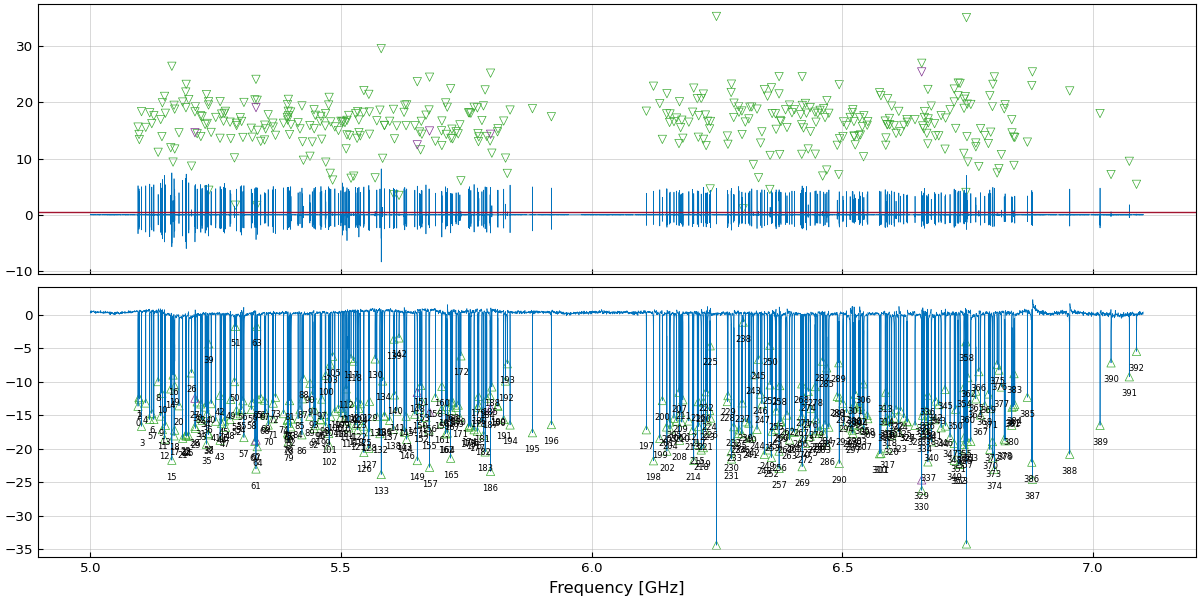

In [4]:
mph = .5
min_df = .1
smooth_avg_s21 = smooth_sweep(avg_s21)
d2s21 = np.diff(smooth_avg_s21, 2)

# init_locs, props = find_peaks(d2s21, height=mph, prominence=mph)
init_locs, props = find_peaks(-avg_s21, height=mph, prominence=mph)
heights = props['peak_heights']

init_locs, unique_mask = track_tones(smooth_avg_s21, init_locs)
# unique_mask[414] = 0

init_f0s = freqs[init_locs]
s21_mins = smooth_avg_s21[init_locs]

# BEGIN:
too_close_mask = np.zeros(init_f0s.shape, dtype=bool)
for i in range(len(init_f0s) - 1):
    if np.abs(init_f0s[i] - init_f0s[i + 1]) < min_df*1e-3 and (unique_mask[i] and unique_mask[i + 1]):
        if s21_mins[i] < s21_mins[i + 1]:
            too_close_mask[i + 1] = True
        else:
            too_close_mask[i] = True

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[2:], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_avg_s21, lw=.5)
# ax['b'].plot(freqs, s21s[0], lw=.5, ls='--')
ax['a'].axhline(mph, c='r')
mask = ~too_close_mask & unique_mask
ax['a'].scatter(freqs[init_locs[mask]], heights[mask], marker='v', c='None', edgecolor='g')
ax['b'].scatter(init_f0s[mask], s21_mins[mask], marker='^', c='None', edgecolor='g')
ax['a'].scatter(freqs[init_locs[too_close_mask]], heights[too_close_mask], marker='v', c='None', edgecolor='p')
ax['b'].scatter(init_f0s[too_close_mask], s21_mins[too_close_mask], marker='^', c='None', edgecolor='p')
ax['a'].scatter(freqs[init_locs[~unique_mask]], heights[~unique_mask], marker='v', c='None', edgecolor='r')
ax['b'].scatter(init_f0s[~unique_mask], s21_mins[~unique_mask], marker='^', c='None', edgecolor='r')
for i, loc in enumerate(init_locs):
    ax['b'].annotate(f'{i}', (init_f0s[i], s21_mins[i]-5), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
ax['b'].set_xlabel('Frequency [GHz]')
print('Total: ', len(init_locs))
print('Too close, within', min_df, 'MHz: ', len(init_locs[too_close_mask]), ', ids: ', np.arange(len(init_locs))[too_close_mask])
print('Overlapping: ', len(init_locs[~unique_mask]), ', ids: ', np.arange(len(init_locs))[~unique_mask])

Mean prominence:  12.116565090680957
total:  393
nr doubles:  8
[12, 15, 24, 133, 165, 227, 359, 382]
Mean prominence:  2.9065808284385017e-15
total:  393
nr doubles:  0
[]
[133, 134, 166, 167, 229, 230, 296, 297, 363, 364]


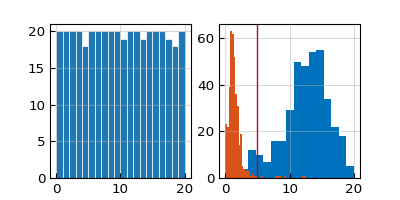

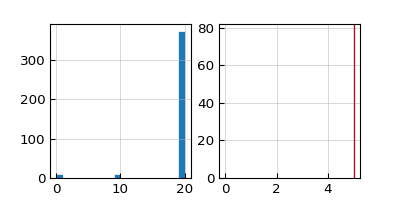

In [5]:
mask = unique_mask
locs = init_locs[mask]
f0s = init_f0s[mask]

ds21s_rows = readout_tones(locs, s21s_rows, avg_s21)
ds21s_cols = readout_tones(locs, s21s_cols, avg_s21)

mpp = 5
rows, maxproms, secproms, doubles = get_pos(ds21s_rows, mpp)
cols, _, _, xdoubles = get_pos(ds21s_cols, mpp)


doubles = add_kids([], doubles)
delete = [12, 16, 26, 389]
doubles = del_kids(doubles, delete)
doubles = add_kids(doubles, [296])
# doubles = add_kids(doubles, [465])
print(doubles)

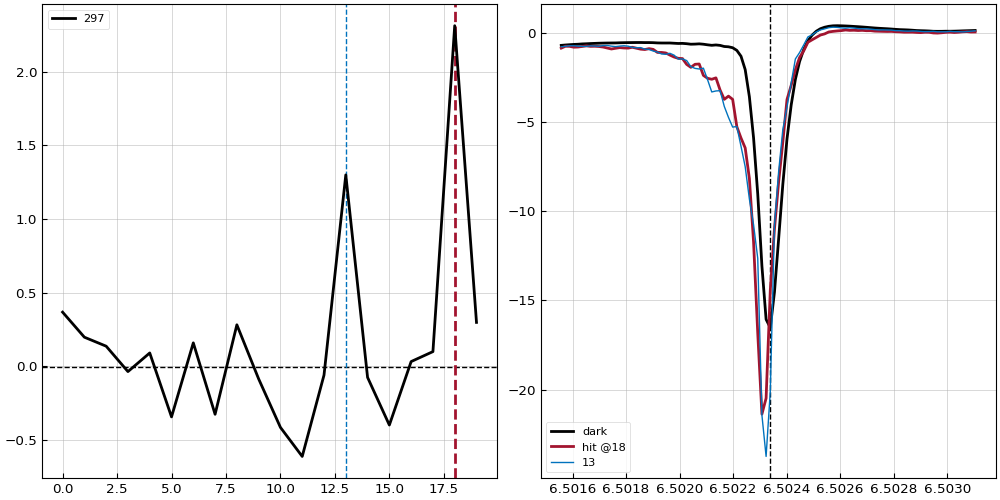

In [6]:
kid = 297
plot_dipshit(s21s_rows, ds21s_rows, rows, [kid], [13])
# plot_dipshit(s21s_cols, ds21s_cols, cols, [kid], [10])

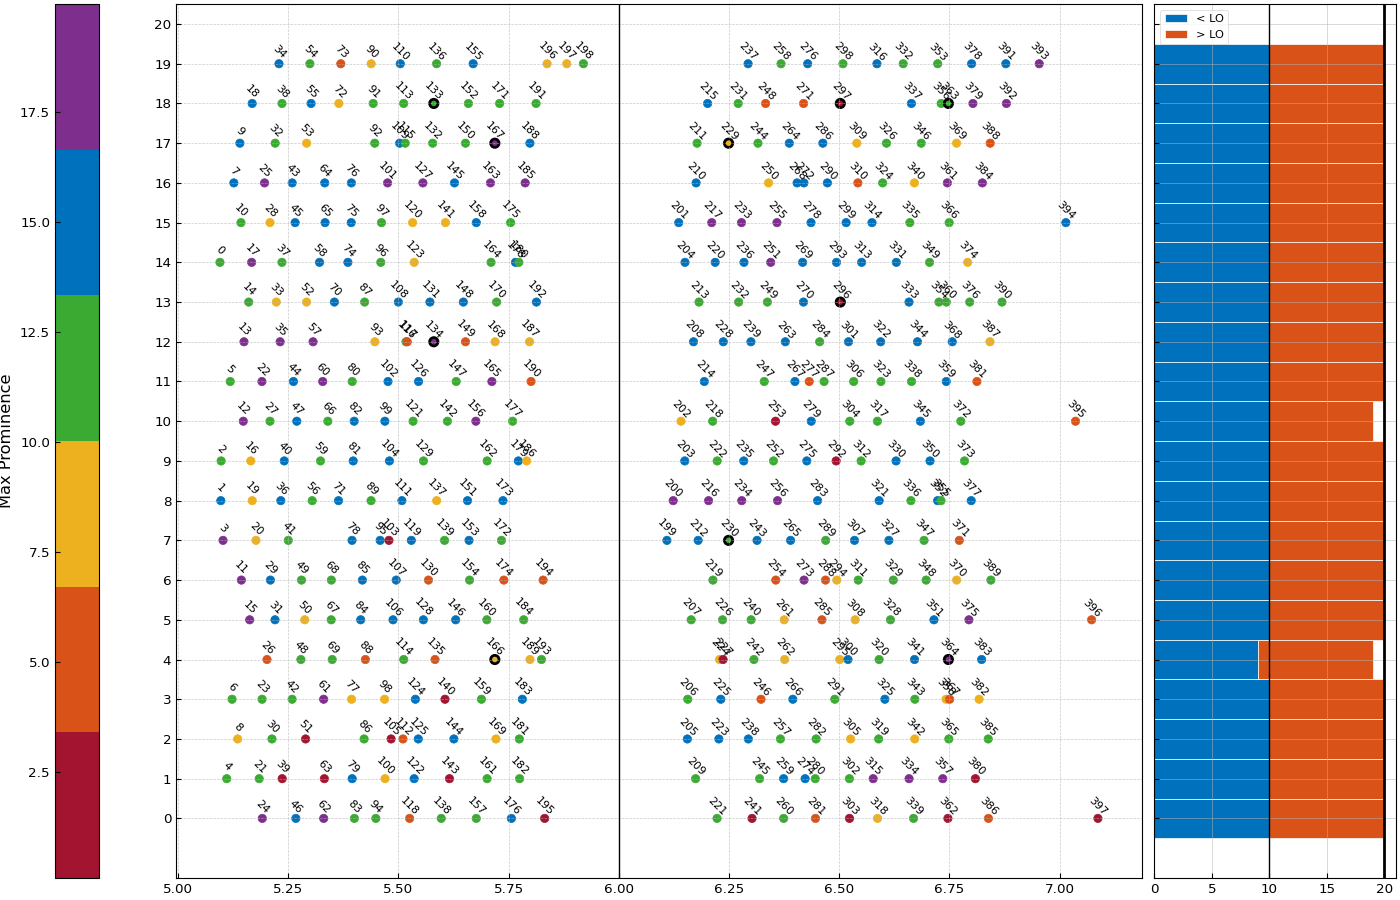

In [7]:
plot_rows(rows, doubles, lo=6)

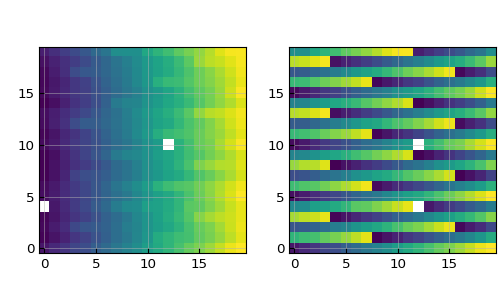

In [8]:
nans = [[4, 0],
        [10, 12],
        ]

kids = map_kids(nans, 8)

In [ ]:
kids2 = np.empty((nr_rows, nr_cols))
kids2[:] = np.nan
for i in range(len(rows)):
    row = int(rows[i])
    col = int(cols[i])
    kid = kids2[row, col]
    if row==0 and col==8:
        print('yeah')
    if np.isnan(kid):
        kids2[row, col] = i
    else:
        if i in doubles:
            kids2[row, col] = -2000
            print(i, row, col)
        else:
            kids2[row, col] = -1000
            print(row, col)
kids2[np.isnan(kids)] = 2000
            
# kids2[0, 30] = 1005
# kids2[0, 10] = 350
# kids2[2, 30] = 349
# kids2[2, 10] = 718

# kids2[0, 8] = 285
# kids2[29, 10] = 284
# kids2[29,8] = 224

# kids2[2, 26] = 216
# kids2[10, 11] = 217
# kids2[2, 11] = 745
# kids2[10, 26] = 700

# kids2[2, 29] = 316
# # 216, 2, 11
# # 217, 10, 26
# kids2[8, 13] = 898
# kids2[7, 13] = np.nan
# # kids2[1, 13] = 236?
# # kids2[7, 17] = 237?

# kids2[9,7] = 407
# kids2[9, 9] = 465
# kids2[17,25] = 466
# kids2[17,9] = 961

# kids2[11, 11] = 904
# kids2[12, 11] = 592

# kids2[10,4] = 10
# kids2[10, 3] = 985
# kids2[4, 7] = 984
# kids[7, 4] = np.nan

print(np.sum(np.isnan(kids2)))
fig, ax = plt.subplots()
ax.imshow(kids2, cmap='viridis', origin='lower', vmin=-2000, vmax=2000)


In [ ]:
print(doubles)
sorted, counts = np.unique(np.vstack((rows, cols)), axis=1, return_counts=True)
nonunique = np.where(counts > 1)[0]
overlapping = []
for i in nonunique:
    row, col = sorted[:, i]
    ids = np.where((rows==row)&(cols==col))[0]
    overlapping.append([ids, [row, col]])
    print(ids, int(row), int(col))

In [ ]:
fig, ax = plt.subplot_mosaic('abcd', figsize=(12,3), constrained_layout=True)
diff_kids = kids-kids2
ax['a'].imshow(kids, cmap='viridis', origin='lower')
ax['a'].set_title('row map')
ax['b'].imshow(kids2, cmap='viridis', origin='lower')
ax['b'].set_title('row+col map')
ax['c'].imshow(diff_kids, cmap='viridis', origin='lower', vmin=-1, vmax=1)
ax['c'].set_title('difference map')

swaps = [[20, [0, -1]], [4,[0, -1]],[3,[0, -1]],[1,[0, -1]],[5,[16, 17]],[11,[0, -1]]]
for row, [a,b] in swaps:
    kids[row, a], kids[row, b] = kids[row, b], kids[row, a]

diff_kids = kids-kids2
ax['d'].imshow(diff_kids, cmap='viridis', origin='lower', vmin=-1, vmax=1)
ax['d'].set_title('corrected map')


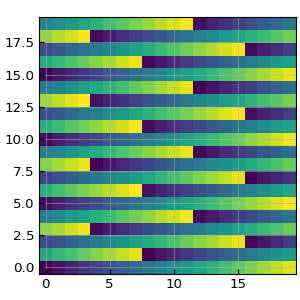

In [9]:
finger_lengths = master['design']['fingers']
design_f0s = master['design']['f0']
coupler_lengths = master['design']['couplers']
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kid_id_board, cmap='viridis', origin='lower')

master['design']['row'] = np.empty(nr_rows*nr_cols)
master['design']['row'][:] = np.nan
master['design']['col'] = np.empty(nr_rows*nr_cols)
master['design']['col'][:] = np.nan
master['measured'] = {}
master['measured']['f0'] = np.empty(nr_rows*nr_cols)
master['measured']['f0'][:] = np.nan
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        master['design']['row'][idx] = i
        master['design']['col'][idx] = j
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master['measured']['f0'][idx] = meas_f
design = master['design']['f0']
meas = master['measured']['f0']
nanmask = np.isnan(meas)
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)



         2
0.01564 x + 0.8612 x + 0.2629
scatter = 0.7%
yield = 99.5%


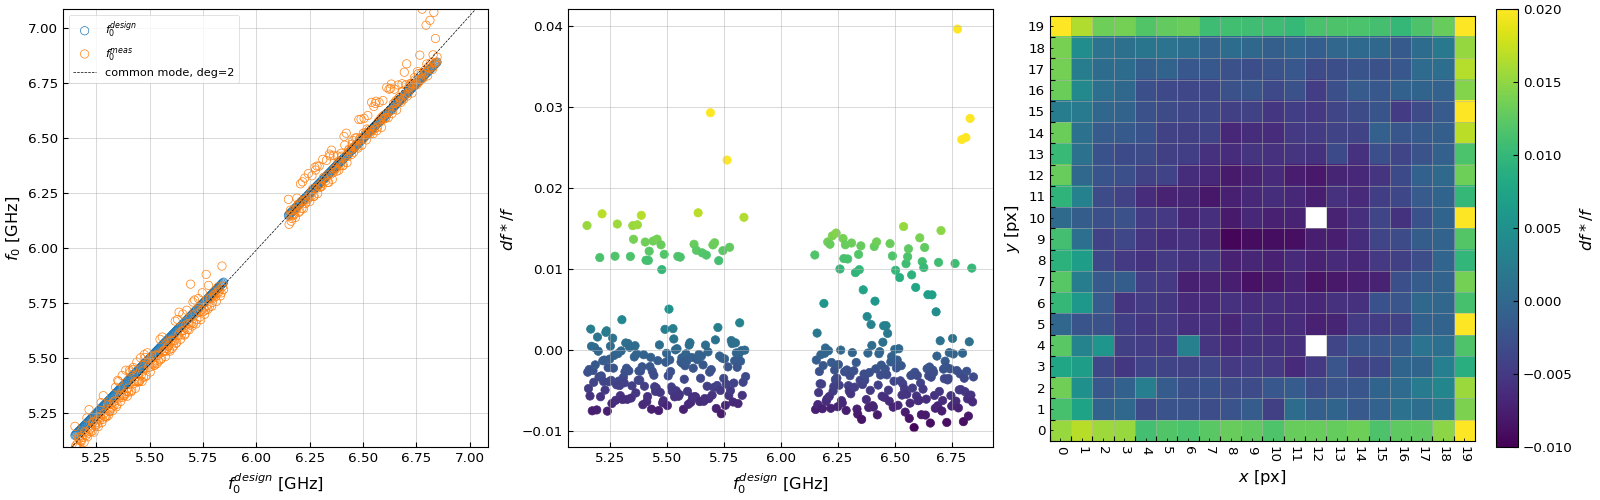

In [10]:
plot_scatter(2, clim=[-0.01, 0.02], annotate=0)

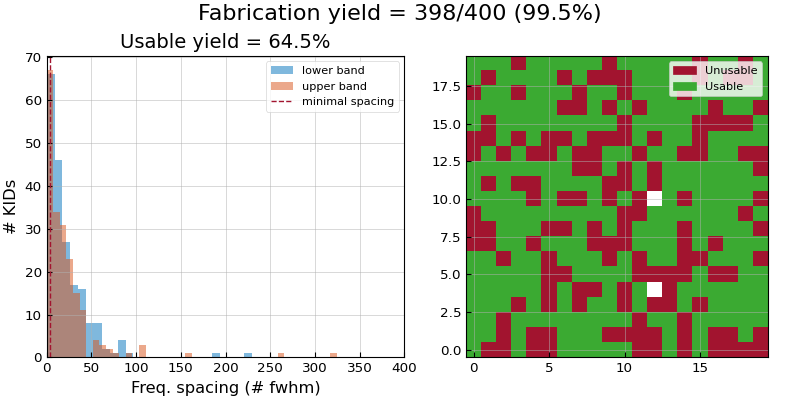

In [12]:
def plot_spacings(f0s, Q, threshold, ax=None):
    argnans = np.isnan(f0s)
    argsort = np.argsort(f0s[~argnans])
    sorted_f0s = f0s[~argnans][argsort]
    if not ax:
        fig, ax = plt.subplots()
    diffs = np.diff(sorted_f0s)
    fwhms = sorted_f0s / Q
    rel_diffs = diffs/fwhms[:-1]
    lo_id = np.argmax(diffs)
    _ = ax.hist(rel_diffs[:lo_id], bins='auto', alpha=.5, label='lower band')
    _ = ax.hist(rel_diffs[lo_id+1:], bins='auto', alpha=.5, label='upper band')
    ax.axvline(threshold, c='r', ls='--', lw=1, label='minimal spacing')
    ax.set_xlabel('Freq. spacing (# fwhm)')
    ax.set_ylabel('# KIDs')
    ax.legend()
    too_close = rel_diffs<threshold
    suff_spaced = np.ones(sorted_f0s.shape)
    suff_spaced[1:] -= too_close
    suff_spaced[:-1] -= too_close
    suff_spaced = (suff_spaced==True)
    total = len(f0s)
    usable_yield = np.sum(suff_spaced) / total
    usable_ids = np.empty(f0s.shape)
    usable_ids[:] = np.nan
    usable_ids[~argnans] = suff_spaced[np.sort(argsort)]
    return usable_yield, usable_ids


fig, axes = plt.subplot_mosaic('cd', figsize=(8,4), constrained_layout=True)
kids_found = np.sum(~np.isnan(meas))
fig.suptitle('Fabrication yield = %d/%d (%.1f%%)' % (kids_found, nr, kids_found/nr*1e2), fontsize=16)
ax = axes['c']
threshold = 4
Q = 30e3
f0s_pretrim = master['measured']['f0']
usable_yield, usable_kids = plot_spacings(f0s_pretrim, Q, threshold, ax)
ax.set_title('Usable yield = %.1f%%' % (usable_yield*1e2))
_ = ax.set_xlim(0, 400)
ax = axes['d']
custom_colors = ['r', 'g']
custom_cmap = mpl.colors.ListedColormap(custom_colors)
ax.imshow(usable_kids[kid_id_board], cmap=custom_cmap, origin='lower', vmin=-1, vmax=2)
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in custom_colors]
ax.legend(handles, ['Unusable', 'Usable'], loc='upper right')

In [48]:
maps = image(ds21s_rows)

In [ ]:
_ = plot_image(maps[:,:, 13])

In [ ]:
anim = animate_image(maps)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(meas[~nanmask][sort_idx], ls='', marker='o', markersize=2)

In [ ]:
fig, axes = plt.subplot_mosaic('a;b', figsize=(10, 5))
ax = axes['a']
sorted_fs = meas[~nanmask][sort_idx]
ids = np.arange(len(meas))[~nanmask]
nr_kids = len(sorted_fs)
nr_lower = 198
nr_upper = nr_kids - nr_lower
ax.scatter(ids, sorted_fs, label='measured (sorted)', c='b')
lower_f0s = rel_freqs(sorted_fs[3]+0.03, sorted_fs[nr_lower-1]-0.01, nr_lower+1)-0.006
upper_f0s = rel_freqs(sorted_fs[nr_lower+12], sorted_fs[-5]-0.04, nr_kids-(nr_lower+1))
lower_ids = ids[:nr_lower+1]
upper_ids = ids[nr_lower+1:]
ax.scatter(lower_ids, lower_f0s, c='o')
ax.scatter(upper_ids, upper_f0s, c='y')
ax = axes['b']
ax.scatter(lower_ids, sorted_fs[:nr_lower+1]-lower_f0s, c='o')
ax.scatter(upper_ids, sorted_fs[nr_lower+1:]-upper_f0s, c='y')
# ax.legend()

nibble_freqs = np.hstack((lower_f0s, upper_f0s))[inverse_sort_idx]
master['trimdesign'] = {}
master['trimdesign']['f0'] = np.empty(nr_rows*nr_cols)
master['trimdesign']['f0'][:] = np.nan
master['trimdesign']['f0'][~nanmask] = nibble_freqs

In [ ]:
fingers = master['design']['fingers']
ids  = np.arange(nr)
trim_design = master['trimdesign']['f0']

fig, axes = plt.subplot_mosaic('aabbee;ccddee', figsize=(15,5), constrained_layout=True)
ax = axes['a']
ax.scatter(design, fingers, label='design f')
ax.scatter(meas, fingers, label='meas f')
ax.scatter(trim_design, fingers, label='nibble f')
ax.set_ylabel('finger length [um]')
ax.set_xlabel('frequency [GHz]')

def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

popt, pcov = curve_fit(poly, meas[~nanmask], fingers[~nanmask])
fit_fingers = poly(meas, *popt)   
ax.plot(meas, fit_fingers, c='k', lw=1)	
new_fingers = poly(trim_design, *popt)
nibble_fingers = new_fingers+(fingers-fit_fingers)
# trims = copy(meas)
trims = nibble_fingers - fingers
# trims[trims > 0] = 0
ax.scatter(trim_design, nibble_fingers, c='r', lw=1, label='nibble f+trim')
ax.legend()

ax = axes['b']
ax.scatter(ids, trims)
ax.set_xlabel('kids')
ax.set_ylabel('trim [um]')
ax.axhline(0, c='r')
print('minimum trim = %.3f um' % np.nanmax(trims[trims<0]))
print('maximum trim = %.3f um' % np.nanmin(trims))

ax = axes['c']
ax.scatter(design, design, label='original design')
ax.scatter(design, meas, label='measured')
ax.scatter(design, trim_design, label='nibble design')
ax.set_ylabel('freqency [GHz]')
ax.set_xlabel('design frequency [GHz]')
ax.legend()
ax = axes['d']
secax = ax.twinx()
df = (trim_design[~nanmask][sort_idx][1:]-trim_design[~nanmask][sort_idx][:-1])
df_f = df / trim_design[~nanmask][sort_idx][:-1]
lo = np.argmax(df)
lo_mask = np.ones(len(df), dtype=bool)
lo_mask[lo] = 0
ax.plot(df[lo_mask]*1e3, label='abs. spacing df')
secax.plot(df_f[lo_mask]*1e4, c='o', label='rel. spacing df/f')
ax.set_ylabel('df [MHz]')
secax.set_ylabel('df/f $\\times 10^4 $')
ax.set_xlabel('kids')
ax.legend()
secax.legend()
ax = axes['e']
ax.imshow(trims[kid_id_board], origin='lower')
master['trimdesign']['fingers'] = nibble_fingers
master['trimdesign']['fingers'][trims>0] = fingers[trims>0]
master['trimdesign']['f0'][trims>0] = meas[trims>0]
# master['trimdesign']['fingers'][invalid] = 0
print('Frequenty range: %.2f-%.2f GHz' % (np.nanmin(nibble_freqs), np.nanmax(nibble_freqs)))
print('LO gap: %d MHz at %.2f GHz' % (np.nanmax(df)*1e3, (nibble_freqs[np.argmax(df)]+nibble_freqs[np.argmax(df)+1])/2))
print('%d pixels > 0: ' % (np.sum(trims > 0)), np.argwhere(trims > 0))

In [69]:
# np.save(path + chip + '_Lf_trim_chip6.npy', master['trimdesign']['fingers'])
# with open('LT402chip6_masterv2.pkl', 'wb') as f:
#     pickle.dump(master, f)
    

In [59]:
from scipy.optimize import fsolve


def find_roots(f1s, l1s, l2s):
    f2s = np.empty(f1s.shape)
    for i in range(len(f1s)):
        f1 = f1s[i]
        l1 = l1s[i]
        l2 = l2s[i]
        if np.isnan(f1) or np.isnan(l1) or np.isnan(l2):
            f2s[i] = np.nan
        else:
            y1 = poly(f1, *popt)
            dl = l1 - y1
            y2  = l2 - dl
            f2 = fsolve(lambda x: poly(x, *popt) - y2, 5)[0]
            f2s[i] = f2
    return np.array(f2s)

In [ ]:
l2s = np.load(path + chip + '_trim_Lf_chip6.npy')
with open(path + 'LT402chip6_master.pkl', 'rb') as f:
    m = pickle.load(f)
l1s = m['trimdesign']['fingers']
f1s = m['trimdesign']['f0']
f2s = find_roots(f1s, l1s, l2s)

fig, ax = plt.subplot_mosaic('abcd')
ids = np.arange(len(f1s))
ax['a'].scatter(ids, l1s, label='master')
ax['a'].scatter(ids, l2s, label='masker')
ax['a'].legend()
ax['b'].scatter(ids, l1s-l2s)
ax['c'].scatter(ids, f2s-f1s)
sorted_f2s = np.sort(f2s[~np.isnan(f2s)])
ax['d'].plot((sorted_f2s[1:]-sorted_f2s[:-1])/sorted_f2s[:-1])
m['trimdesign masker'] = {}
m['trimdesign masker']['fingers'] = l2s
m['trimdesign masker']['f0'] = f2s

In [62]:
# with open('LT402chip6_master.pkl', 'wb') as f:
#     pickle.dump(m, f)

In [69]:
np.savetxt('LT402_32x32_4-8GHz_f0_trim_chip6.npy', f2s)